In [70]:
%matplotlib inline

Collection of notes on quantitative trading strategies

The first section of notes are based on Ernest Chan's Algorithmic Trading book.


# Hypothesis Testing for Backtesting

* p-value based, Critical value = $\sqrt{n} \times \text{DailySharpeRatio}$, given $n$ is the number of days in the backtest. critial values: 1.645, 2.326, 3.091 for p values: 0.05, 0.01, 0.001. See coding example below.
* Simulation based, generate price data and feed to strategy
* Andrew Lo: Generate trades based on original historical price series, constraints: same number of long and short entries as the backtest, with same average holding periods. 



Critical Values are based on normal distributio with 0 mean and unit variance. 

The test statistic is caluclated as, [link](http://artmathonline.com/files/hypothesisteststeps1.pdf), [code](https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa-in-python)

$$ z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} = \sqrt{n} \times \frac{\bar{x} - \mu}{\sigma}$$

This can be done with `scipy.stats.ttest_1samp(daily_returns)`.

In [1]:
import statsmodels.stats.weightstats as ssw
import numpy as np
import scipy.stats as ss

In [44]:
ss.norm.ppf(.9)

1.2815515655446004

In [43]:
ss.norm.ppf(.95)

1.6448536269514722

In [45]:
ss.norm.ppf(.99)

2.3263478740408408

In [46]:
ss.norm.ppf(.999)

3.0902323061678132

From critical value to p-value:

In [49]:
ss.norm.cdf(2.5)

0.99379033467422384

In [8]:
rtns = np.random.rand(252) / 10.

In [59]:
cval = np.mean(rtns) / sd * np.sqrt(252)
cval

25.402687920083974

In [60]:
1 - ss.norm.cdf(cval)

0.0

In [62]:
ss.ttest_1samp(rtns, popmean=0)

Ttest_1sampResult(statistic=25.402687920083977, pvalue=2.5044480595647219e-71)

# Mean Reversion

## ADF test

Essentially this is testing whether the **beta coefficient** for 1-day lagged returns in an autoregressive model is **zero**. If the null hypothesis that beta equals zero is rejected, then the time series is **not a random walk**.

In a mean reversion setting, we expect beta to be **negative**

## Hurst Exponent 

H = 0.5 indicates geometric random walk. H < 0.5 indicates mean reversion, H > 0.5 indicates trending series.

## Variance Ratio Test

Statistical test for Hurst exponent, null hypothesis is that the time series is a random walk. Small p-values rejects this hypothesis.

## Half-Life of Mean Reversion

see this [notebook](\../notebooks/git/notebooks/python/time_series.ipynb)

Based on O-U process formula in discrete time scale.

** half-life** $= -\log(2)/\lambda$, implying that $\lambda$ should be **negative** for mean reverting series. 

where $\lambda$ is the beta based on regressing price change versus lagged price: `px_{t} - px_{t-1} ~ px_{t-1} + 1`.

In a strategy, half-life is used as the rolling average window for z-scoring.

In [63]:
import pandas as pd

In [72]:
import pyhistdata as phd

In [74]:
cad = phd.load_fx('USDCAD', source_dir='/home/zwl/data/fx/csv')

In [75]:
cadx = cad.loc['2007-07-22':'2012-03-28']

In [76]:
cad_d = cadx.resample('B').last()

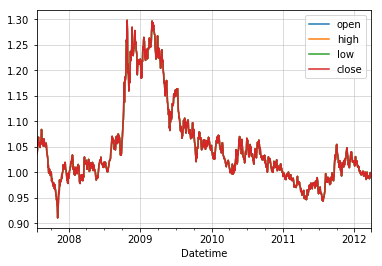

In [77]:
cad_d.plot()

In [78]:
close = cad_d.close
df = pd.DataFrame(dict(chg=close.diff(), lag=close.shift(1)))
df.tail()

,chg,lag
Datetime,,
2012-03-22,0.00659,0.99292
2012-03-23,-0.00214,0.99951
2012-03-26,-0.00577,0.99737
2012-03-27,0.00431,0.99160
2012-03-28,0.00232,0.99591


In [79]:
import statsmodels.formula.api as sm

In [86]:
m = sm.ols('chg ~ lag', data=df.dropna()).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.167
Date:                Wed, 12 Jul 2017   Prob (F-statistic):             0.0754
Time:                        00:41:30   Log-Likelihood:                 4091.3
No. Observations:                1219   AIC:                            -8179.
Df Residuals:                    1217   BIC:                            -8168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0056      0.003      1.764      0.078      -0.001       0.012
lag           -0.0054      0.003     -1.780      0.075      -0.011       0.001
==============================================================================
Omnibus:                      201.569   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2862.820
Skew:                          -0.258   Prob(JB):                         0.00
Kurtosis:                      10.490   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
# half life
-np.log(2) / m.params[1]

127.99596750671017

## Cointegration

### CADF test

Testing for mean reversion for spread of a pair of securities. When using CADF, the order of variables matters, so need to try different order (dependent vs independent) to find the best p-value order, to obtain the hedge ratio.

### Johansen Test

See `R`'s `urca` package. 

Johansen test is independent of the order of the price series, it tests all the independent cointegrating relations that exist.

The eigenvalues are the hedge ratios.

see this [notebook](\../notebooks/git/notebooks/python/time_series.ipynb) for more on this topic, including Philipp-Ouliaris (PO) test.

